In [1]:
siteinfo_file = 'flowdata/siteinfo.tsv'

usgs_sfcwater_url = "https://waterdata.usgs.gov/wa/nwis/dv?referred_module=sw&search_criteria=search_site_no&submitted_form=introduction"
start_date = "1940-09-30"

from mechanize import Browser
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import os
import calendar
import re
from scipy.interpolate import interp1d
import scipy.stats
import contextily as cx
from adjustText import adjust_text

import streamutil
from apis import API_KEYS

In [2]:
siteinfo_gdf = streamutil.get_site_info_gdf(siteinfo_file)
siteinfo_gdf

,Agency,Full Name,Name,geometry
Site,,,,
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481)
12048000,USGS,"DUNGENESS RIVER NEAR SEQUIM, WA",Dungeness River,POINT (-123.13268 48.01426)
12052000,USGS,"LITTLE QUILCENE RIVER NEAR QUILCENE, WA",Little Quilcene River,POINT (-122.88739 47.83731)
12052210,USGS,BIG QUILCENE RIVER BELOW DIVERSION NR QUILCENE...,Big Quilcene River,POINT (-122.97961 47.78454)
12053000,USGS,"DOSEWALLIPS RIVER NEAR BRINNON, WA",Dosewallips River,POINT (-123.00961 47.72620)
12054000,USGS,"DUCKABUSH RIVER NEAR BRINNON, WA",Duckabush River,POINT (-123.01155 47.68398)
12059500,USGS,"NORTH FORK SKOKOMISH RIVER NEAR POTLATCH, WA",North Fork Skokomish River,POINT (-123.24321 47.32981)
12060500,USGS,"SOUTH FORK SKOKOMISH RIVER NEAR UNION, WA",South Fork Skokomish River,POINT (-123.28016 47.34037)
12063500,USGS,"UNION RIVER NEAR BELFAIR, WA",Union River,POINT (-122.82737 47.47204)


In [3]:
br = Browser()
for streamid,streamname in zip(siteinfo_gdf.index,siteinfo_gdf['Full Name']):
    outfile = f'flowdata/{streamid} {streamname}.tsv.gz'
    if os.path.exists(outfile):
        continue
    br.open(usgs_sfcwater_url)
    br.select_form("select_sites_data")
    br.set_value(str(streamid), "search_site_no")
    br.set_single(True, "index_pmcode_00060") # Return only flow
    br.find_control("range_selection").get("date_range").selected = True
    br.set_value(start_date, "begin_date")
    br.find_control("format").get("rdb").selected = True # Tab-separated data
    br.find_control("rdb_compression").get("gz").selected = True # download gzipped file
    req = br.click(id="search_submit_button")
    response = br.open(req)
    with open(outfile, "wb") as out:
        out.write(response.read())

In [4]:
all_flows = pd.concat(streamutil.get_all_flows("flowdata", siteinfo_gdf).values())
all_flows.head()

,Agency,Site,Flow,Flags
Date,,,,
2008-10-02,USGS,12210000,5.77728,A
2008-10-03,USGS,12210000,6.23040,A
2008-10-04,USGS,12210000,13.82016,A
2008-10-05,USGS,12210000,22.85424,A
2008-10-06,USGS,12210000,12.51744,A


In [5]:
avail_stats = {
    "Site": [],
    "Name": [],
    "Start": [],
    "End": [],
    "Missing": []
}
for g, group in all_flows.groupby('Site'):
    pruned = group.dropna()
    dates = pruned.index.sort_values()
    siteinfo_gdf.loc[g, "Start"] = dates[0]
    siteinfo_gdf.loc[g, "End"] = dates[-1]
    siteinfo_gdf.loc[g, "Missing"] = len(pd.date_range(dates[0], dates[-1], freq="1D").difference(pruned.index))
siteinfo_gdf

,Agency,Full Name,Name,geometry,Start,End,Missing
Site,,,,,,,
12045500,USGS,"ELWHA RIVER AT MCDONALD BR NEAR PORT ANGELES, WA",Elwha River,POINT (-123.58325 48.05481),1940-10-02,2023-11-19,0.0
12048000,USGS,"DUNGENESS RIVER NEAR SEQUIM, WA",Dungeness River,POINT (-123.13268 48.01426),1940-10-02,2023-11-19,6.0
12052000,USGS,"LITTLE QUILCENE RIVER NEAR QUILCENE, WA",Little Quilcene River,POINT (-122.88739 47.83731),1951-07-02,1957-12-31,0.0
12052210,USGS,BIG QUILCENE RIVER BELOW DIVERSION NR QUILCENE...,Big Quilcene River,POINT (-122.97961 47.78454),1994-01-22,2023-11-19,100.0
12053000,USGS,"DOSEWALLIPS RIVER NEAR BRINNON, WA",Dosewallips River,POINT (-123.00961 47.72620),1940-10-01,1951-09-29,609.0
12054000,USGS,"DUCKABUSH RIVER NEAR BRINNON, WA",Duckabush River,POINT (-123.01155 47.68398),1940-10-02,2023-11-19,0.0
12059500,USGS,"NORTH FORK SKOKOMISH RIVER NEAR POTLATCH, WA",North Fork Skokomish River,POINT (-123.24321 47.32981),1944-04-02,2023-11-19,111.0
12060500,USGS,"SOUTH FORK SKOKOMISH RIVER NEAR UNION, WA",South Fork Skokomish River,POINT (-123.28016 47.34037),1940-10-02,2023-11-19,4017.0
12063500,USGS,"UNION RIVER NEAR BELFAIR, WA",Union River,POINT (-122.82737 47.47204),1947-07-02,1959-09-29,0.0


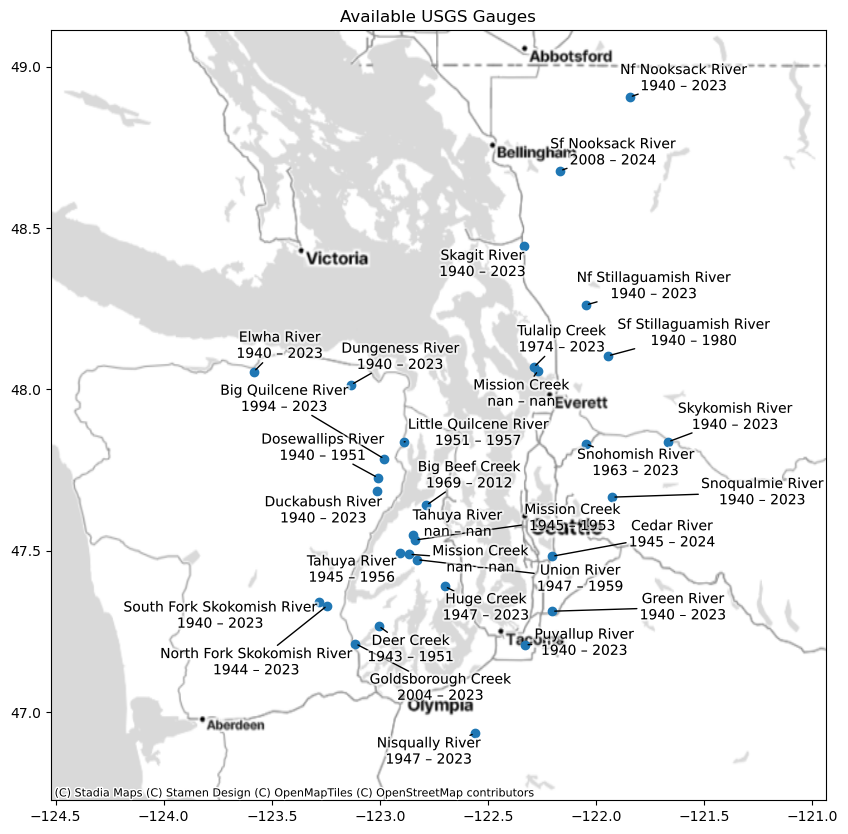

In [6]:
ax = siteinfo_gdf.plot(figsize=(10,10))
xmin, xmax, ymin, ymax = ax.axis()
ax.set(title="Available USGS Gauges",
    #xbound=(xmin, xmax + 0.2 * (xmax - xmin)),
    #ybound=(5170000, None),
    xbound=(xmin - 0.4 * (xmax - xmin), xmax + 0.3 * (xmax - xmin)),
    ybound=(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))
    #xticklabels=(), yticklabels=()
)
texts = []
for i,row in siteinfo_gdf.iterrows():
    texts.append(
        ax.annotate(f"{row['Name']}\n{row['Start'].year} – {row['End'].year}",
                    xy=(row['geometry'].x, row['geometry'].y),
                    ha='center', va='center', path_effects=[
                        pe.withStroke(linewidth=3, foreground='white',
                                      alpha=0.6)
                    ]))
adjust_text(texts, siteinfo_gdf['geometry'].x.to_numpy(), siteinfo_gdf['geometry'].y.to_numpy(),
                #force_points=(0.4, 1),
                ax=ax, arrowprops=dict(arrowstyle='-'))
tileset = cx.providers.Stadia.StamenTonerLite
tileset['url'] = 'https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=' + API_KEYS['stadia']
cx.add_basemap(ax, crs=siteinfo_gdf.crs, source=tileset)

Limit the analysis to the beginning of the record for the latest stream in the set

In [7]:
set_begin_date = all_flows.reset_index().groupby("Site")["Date"].min().max()
all_flows = all_flows.loc[all_flows.index >= set_begin_date]

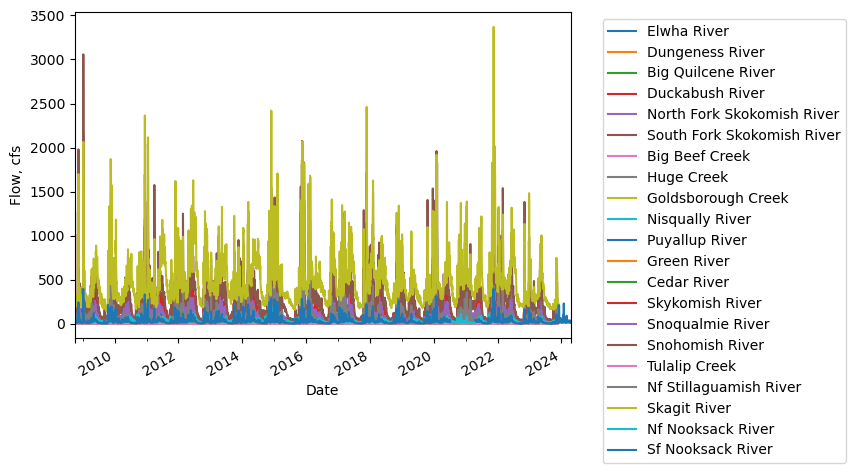

In [8]:
fig, ax = plt.subplots()
for g, group in all_flows.groupby('Site'):
    group['Flow'].plot(ax=ax, label=siteinfo_gdf.loc[g, 'Name'])
ax.legend(bbox_to_anchor=(1.05,1))
ax.set_ylabel("Flow, cfs")
fig.autofmt_xdate()

In [9]:
water_year_groupby = all_flows.groupby(all_flows.index.to_period('Y-SEP'))
days_per_year = [365 + calendar.isleap(k.year) for k in water_year_groupby.groups.keys()]
water_year_totals = water_year_groupby['Flow'].sum() / days_per_year
# Drop the last water year as it's incomplete
water_year_totals.drop(water_year_totals.tail(1).index, inplace=True)
water_year_totals

Date
2009    1229.250821
2010    1320.544707
2011    1630.317585
2012    1523.179352
2013    1464.980764
2014    1451.809258
2015    1254.149654
2016    1468.992620
2017    1498.292143
2018    1449.515427
2019    1053.206164
2020    1427.421017
2021    1389.877703
2022    1699.489410
2023     959.764971
Freq: Y-SEP, Name: Flow, dtype: float64

Text(0.5, 0.98, 'Water Year Total Flows, 2009 - 2023')

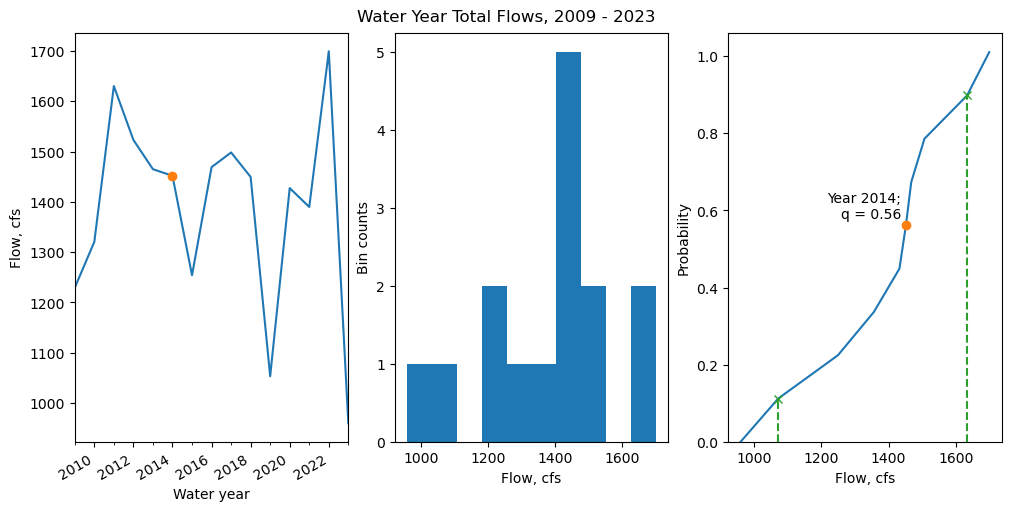

In [10]:
target_year = 2014
fig, (tsax,histax,quantax) = plt.subplots(1, 3, figsize=(10,5), constrained_layout=True)
water_year_totals.plot(ax=tsax)
target_total = water_year_totals[str(target_year)]
tsax.plot(water_year_totals[water_year_totals == target_total].index, target_total, marker="o")
tsax.set(ylabel="Flow, cfs", xlabel="Water year")
plt.setp(tsax.get_xticklabels(), rotation=30, ha='right')

histax.hist(water_year_totals, bins=10)
histax.set(xlabel="Flow, cfs", ylabel="Bin counts")

p = np.linspace(0, 1.01, 10)
quants = scipy.stats.mstats.mquantiles(water_year_totals, prob=p)
quant_pinterp = interp1d(quants, p)
quantax.plot(quants, p)
target_q = quant_pinterp(target_total)
target_mark = quantax.plot(target_total, target_q, marker="o")
quantax.text(target_total * 0.99, target_q + 0.01, "Year {0};\nq = {1:.2f}".format(target_year, target_q),
             horizontalalignment="right", verticalalignment="bottom")
bound_marks = quantax.plot((quants[1,],quants[-2]), (p[1],p[-2]), "x")
quantax.plot((quants[1], quants[1]), (0, p[1]), color=bound_marks[0].get_color(), linestyle="--")
quantax.plot((quants[-2], quants[-2]), (0, p[-2]), color=bound_marks[0].get_color(), linestyle="--")
quantax.set(ylim=(0,None), xlabel="Flow, cfs", ylabel="Probability")
fig.suptitle("Water Year Total Flows, {0} - {1}".format(water_year_totals.index[0], water_year_totals.index[-1]))

In [11]:
multipliers = quants.take((0,1,-2,-1)) / target_total
multipliers

array([0.661082  , 0.73827038, 1.12515804, 1.17060103])

In [12]:
all_flows.loc[(all_flows.index >= pd.Timestamp("2012-10-01")) & (all_flows.index <= pd.Timestamp("2013-09-30")), "Flow"].sum()

534717.9790224

In [13]:
','.join(siteinfo_gdf.index.astype(str))

'12045500,12048000,12052000,12052210,12053000,12054000,12059500,12060500,12063500,12064500,12065000,12066000,12067500,12069550,12073500,12075000,12076800,12089500,12101500,12113000,12119000,12134500,12149000,12150800,12157250,12158040,12161000,12167000,12200500,12205000,12210000'